In [1]:
from funciones_LSTM import *
import holidays
from joblib import dump, load

In [2]:
np.random.seed(42)

In [4]:
df = pd.read_parquet('data_export/prueba_ml.parquet')
df.reset_index(inplace=True, drop=True)
df['dia_semana'] = df['fecha'].dt.weekday + 1
year = 2023
us_holidays = holidays.US(years=year)
us_holidays
df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)
df['rain'] = df['rain'].shift(1)
df['snowfall'] = df['snowfall'].shift(1)
df.fillna(0.0, inplace=True)
columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
X = df[columnas_X]

columnas_Y= ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
Y = df[columnas_Y]

9/9 [==============================] - 0s 15ms/step - loss: 0.0276
Valor final de Loss: 0.027566401287913322


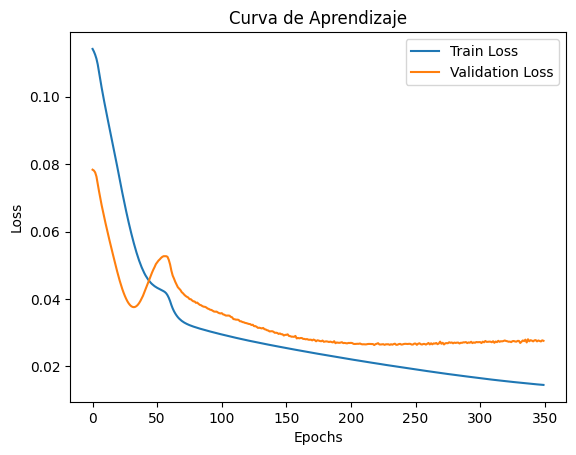

9/9 [==============================] - 2s 7ms/step


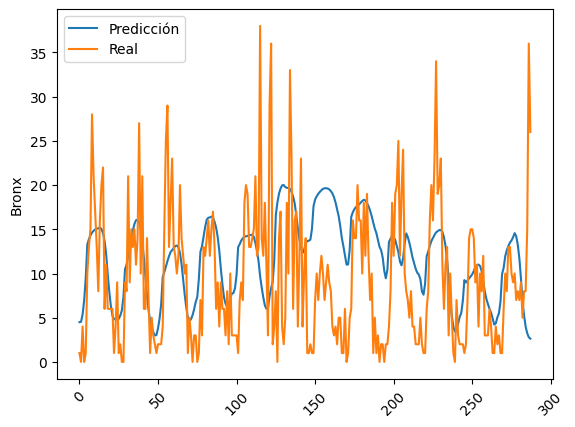

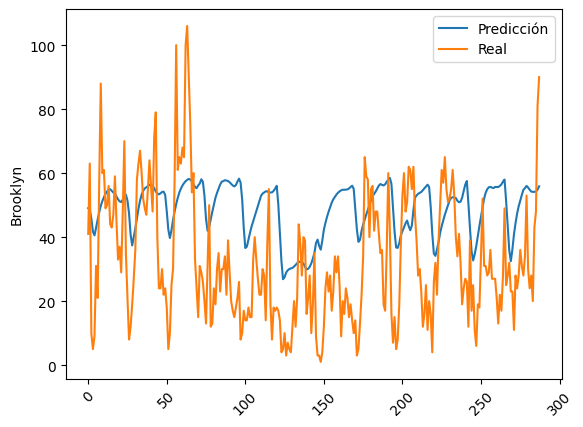

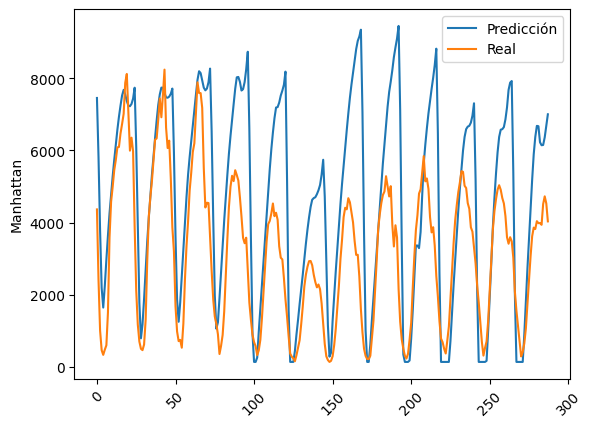

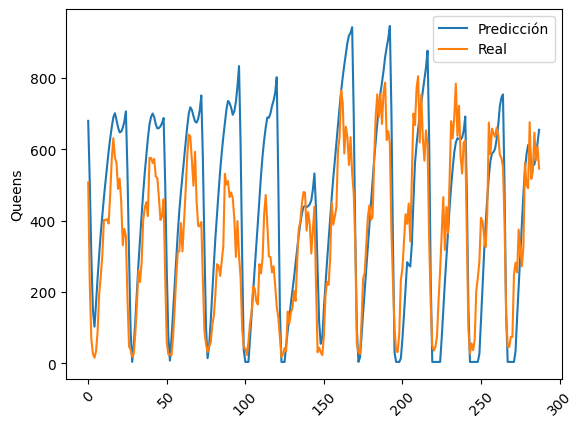

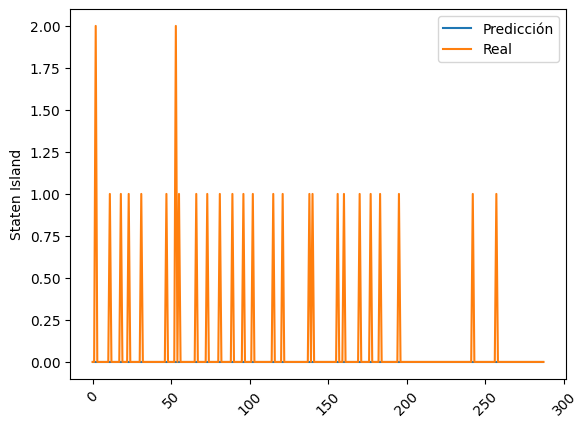

In [6]:
modelo, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped, scores, history, loss = construir_modelo_cv(X, Y, nro_pasos=5, 
                    nro_capas_lstm=2, unidades_capa=[50,40], loss_='mse', act_salida='relu', act_lstm='relu', act_dense='sigmoid', learning_r=0.00001, 
                     epochs=350 )
graficar_curva_aprendizaje(history)
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y)

In [7]:
archivo = 'model_app_1.joblib'

dump(modelo, archivo)
dump(scaler_X, 'scaler_X.joblib')
dump(scaler_Y, 'scaler_Y.joblib')

INFO:tensorflow:Assets written to: C:\Users\alter\AppData\Local\Temp\tmpanjqt0fq\assets


INFO:tensorflow:Assets written to: C:\Users\alter\AppData\Local\Temp\tmpanjqt0fq\assets


['scaler_Y.joblib']

Probemos generar predicciones a partir de datos cargados por el usuario:

In [8]:
cantidad_dias = 7

In [9]:
import openmeteo_requests

import requests_cache
from retry_requests import retry
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 40.71427,
	"longitude": -74.00597,
	"hourly": ["temperature_2m", "relative_humidity_2m", "rain", "snowfall"],
	"timezone": "America/New_York",
	"past_days": 1,
    "forecast_days": cantidad_dias
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall

df = pd.DataFrame(data = hourly_data)
df.head()


Coordinates 40.71033477783203°N -73.99307250976562°E
Elevation 51.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s


,date,temperature_2m,relative_humidity_2m,rain,snowfall
0,2024-04-11 04:00:00+00:00,10.457500,85.0,0.0,0.0
1,2024-04-11 05:00:00+00:00,10.107500,86.0,0.0,0.0
2,2024-04-11 06:00:00+00:00,9.907499,87.0,0.0,0.0
3,2024-04-11 07:00:00+00:00,9.357500,86.0,0.0,0.0
4,2024-04-11 08:00:00+00:00,8.907499,97.0,0.0,0.0


In [10]:
df['fecha'] = df['date'].dt.date
df['año'] = df['date'].dt.year
df['mes'] = df['date'].dt.month
df['dia'] = df['date'].dt.day
df['hora'] = df['date'].dt.hour
df['dia_semana'] = df['date'].dt.weekday + 1
year = 2024
us_holidays = holidays.US(years=year)
us_holidays
df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)
df.head()

,date,temperature_2m,relative_humidity_2m,rain,snowfall,fecha,año,mes,dia,hora,dia_semana,holiday
0,2024-04-11 04:00:00+00:00,10.457500,85.0,0.0,0.0,2024-04-11,2024,4,11,4,4,0
1,2024-04-11 05:00:00+00:00,10.107500,86.0,0.0,0.0,2024-04-11,2024,4,11,5,4,0
2,2024-04-11 06:00:00+00:00,9.907499,87.0,0.0,0.0,2024-04-11,2024,4,11,6,4,0
3,2024-04-11 07:00:00+00:00,9.357500,86.0,0.0,0.0,2024-04-11,2024,4,11,7,4,0
4,2024-04-11 08:00:00+00:00,8.907499,97.0,0.0,0.0,2024-04-11,2024,4,11,8,4,0


In [11]:
from datetime import datetime

hora_actual = datetime.now().time()
fecha_actual = datetime.now().date()
hora = hora_actual.hour
dia = fecha_actual.day
mes = fecha_actual.month
anio = fecha_actual.year

In [12]:
indice = df.loc[(df['año'] == anio) & (df['mes'] == mes) & (df['dia'] == dia) & (df['hora'] == hora)].index[0]

In [13]:
df = df.loc[indice-4:,:]

In [14]:
columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
X = df[columnas_X]

In [15]:
X

,año,mes,dia,hora,dia_semana,holiday,temperature_2m,rain,relative_humidity_2m,snowfall
32,2024,4,12,12,5,0,13.307501,0.0,95.0,0.0
33,2024,4,12,13,5,0,14.257500,0.0,89.0,0.0
34,2024,4,12,14,5,0,15.107500,0.0,94.0,0.0
35,2024,4,12,15,5,0,14.457500,0.0,100.0,0.0
36,2024,4,12,16,5,0,16.007500,0.0,89.0,0.0
...,...,...,...,...,...,...,...,...,...,...
187,2024,4,18,23,4,0,15.953001,0.0,81.0,0.0
188,2024,4,19,0,5,0,14.303000,0.0,87.0,0.0
189,2024,4,19,1,5,0,13.403000,0.0,90.0,0.0
190,2024,4,19,2,5,0,12.803000,0.0,90.0,0.0


In [16]:
modelo = load('model_app_1.joblib')
scaler_X = load('scaler_X.joblib')
scaler_Y = load('scaler_Y.joblib')
X_scaled = scaler_X.transform(X)

In [17]:
X_reshaped = generador_X(X_scaled, p=5)

5/5 [==============================] - 0s 4ms/step


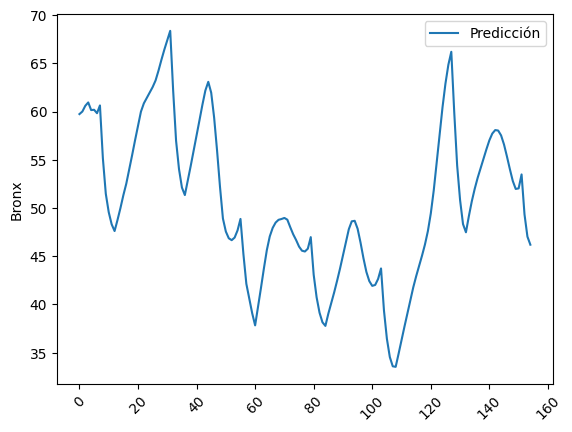

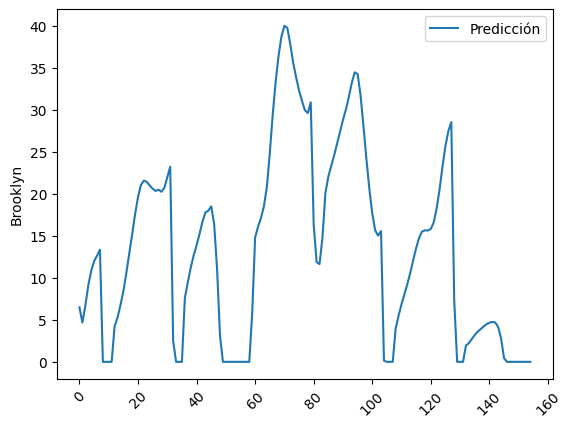

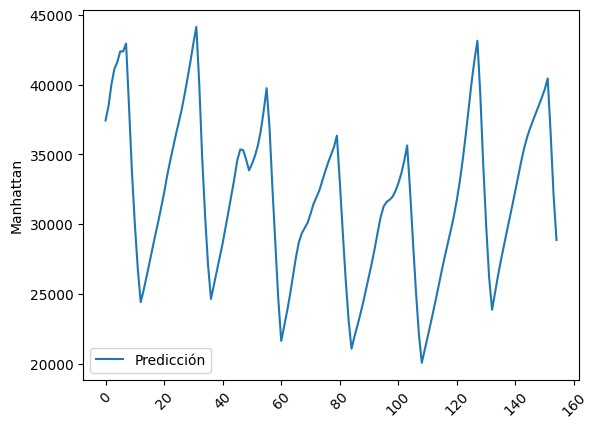

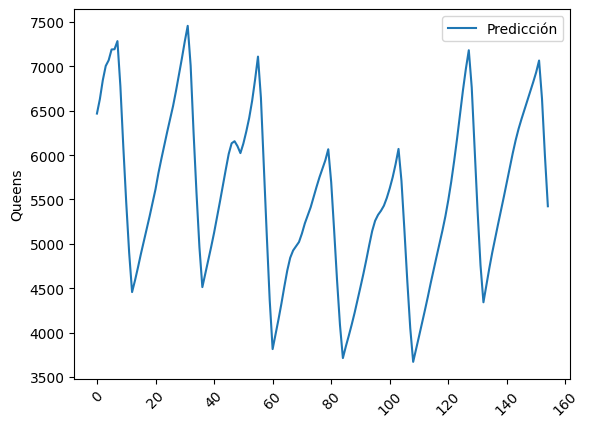

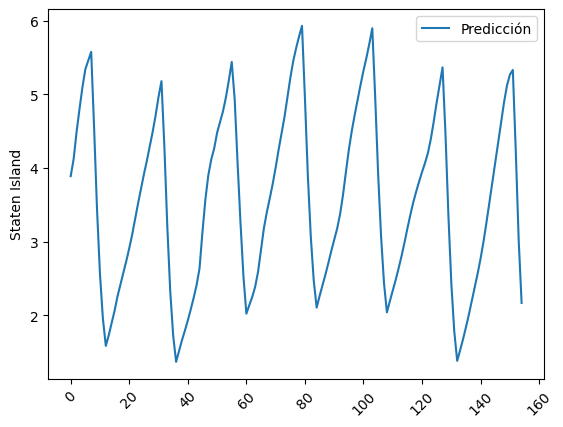

In [18]:
Y_predict = modelo.predict(X_reshaped)
Y_predict_df = pd.DataFrame(Y_predict, columns=columnas_Y)
Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
Y_predict_original_df = pd.DataFrame(Y_predict_original, columns=columnas_Y)
columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

for i in columnas_Y:
    sns.lineplot(x=Y_predict_original_df.index, y=Y_predict_original_df[i], label='Predicción')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()